# Data Wrangler Analysis

This notebook loads data from `air_ops.duckdb` into Pandas DataFrames so you can use the VS Code Data Wrangler extension.

## Instructions
1. Run the cells below to load the data.
2. Once the DataFrame is displayed, click the **"Launch Data Wrangler"** button that appears below the cell output in VS Code.

In [1]:
import duckdb
import pandas as pd
from pathlib import Path

# Connect to the database
project_root = Path("..").resolve()
db_path = project_root / "air_ops.duckdb"

con = duckdb.connect(str(db_path), read_only=True)

### Load Enriched Aircraft States
Load a sample of the main enriched table.

In [3]:
df_aircraft = con.execute("SELECT * FROM enriched_aircraft_states LIMIT 10000").df()
df_aircraft.head()

,icao24,origin_country,time_position,last_contact,longitude,latitude,baro_altitude,geo_altitude,on_ground,velocity,...,model,icaoaircrafttype,operator,operatoricao,ModelFullName,AircraftDescription,Description,WTC,climb_rate_ratio,altitude_km
0,a19cb0,United States,2025-12-01T22:26:42+00:00,2025-12-01T22:26:41+00:00,-97.4304,32.9218,1767.84,1737.36,False,85.79,...,58,L2P,None,None,58 Baron,LandPlane,L2P,L,0.0,1.76784
1,a19cb0,United States,2025-12-01T22:26:42+00:00,2025-12-01T22:26:41+00:00,-97.4304,32.9218,1767.84,1737.36,False,85.79,...,58,L2P,None,None,Baron (58),LandPlane,L2P,L,0.0,1.76784
2,a19cb0,United States,2025-12-01T22:26:42+00:00,2025-12-01T22:26:41+00:00,-97.4304,32.9218,1767.84,1737.36,False,85.79,...,58,L2P,None,None,58 Baron,LandPlane,L2P,L,0.0,1.76784
3,a19cb0,United States,2025-12-01T22:26:42+00:00,2025-12-01T22:26:41+00:00,-97.4304,32.9218,1767.84,1737.36,False,85.79,...,58,L2P,None,None,Baron,LandPlane,L2P,L,0.0,1.76784
4,a3a990,United States,2025-12-01T22:26:42+00:00,2025-12-01T22:26:41+00:00,-94.2476,40.4907,9753.60,9525.00,False,212.03,...,A319-114,L2J,None,DAL,VC-1 ACJ,LandPlane,L2J,M,0.0,9.75360


### Load Anomalies
Load the flagged anomalies for analysis.

In [ ]:
df_anomalies = con.execute("""
    SELECT * 
    FROM flagged_anomalies 
    WHERE sudden_velocity_anomaly OR unrealistic_climb_anomaly OR altitude_jump_anomaly
""").df()

df_anomalies.head()

### Load Statistical Anomalies
Load the peer-comparison anomalies.

In [ ]:
df_stats_anomalies = con.execute("SELECT * FROM statistical_anomalies").df()
df_stats_anomalies.head()

In [6]:
bins = [0, 3000, 10000, 30000, 60000]
labels = ["Low (0-3k)", "Climb (3-10k)", "Cruise Low (10-30k)", "High (30k+)"]

df_aircraft['alt_band'] = pd.cut(df_aircraft['geo_altitude'], bins=bins, labels=labels)

df_aircraft.groupby('alt_band').size().sort_values(ascending=False)

/var/folders/r3/w_7frpzn2m9_yscy82mn8cl40000gn/T/ipykernel_9195/2769780209.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aircraft.groupby('alt_band').size().sort_values(ascending=False)


alt_band
Low (0-3k)             6405
Climb (3-10k)          1628
Cruise Low (10-30k)    1433
High (30k+)               0
dtype: int64

In [7]:
df_aircraft.columns

Index(['icao24', 'origin_country', 'time_position', 'last_contact',
       'longitude', 'latitude', 'baro_altitude', 'geo_altitude', 'on_ground',
       'velocity', 'true_track', 'vertical_rate', 'squawk', 'spi',
       'snapshot_ts', 'date', 'registration', 'model', 'icaoaircrafttype',
       'operator', 'operatoricao', 'ModelFullName', 'AircraftDescription',
       'Description', 'WTC', 'climb_rate_ratio', 'altitude_km', 'alt_band'],
      dtype='object')

In [4]:
df = df_aircraft

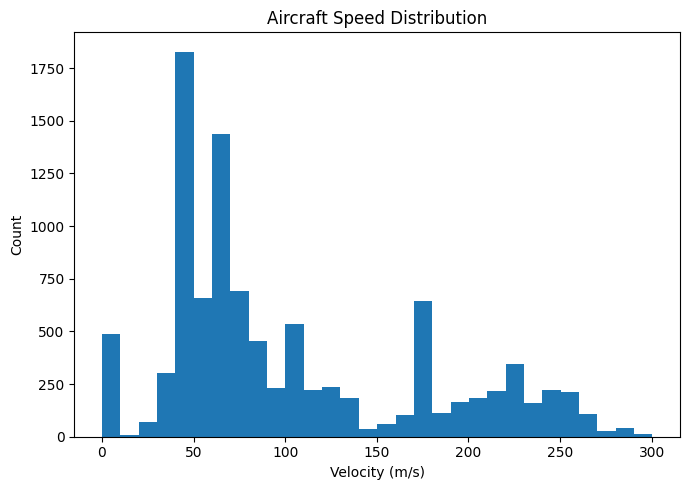

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(7,5))
plt.hist(df['velocity'].dropna(), bins=30)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Count")
plt.title("Aircraft Speed Distribution")
plt.tight_layout()
plt.show()


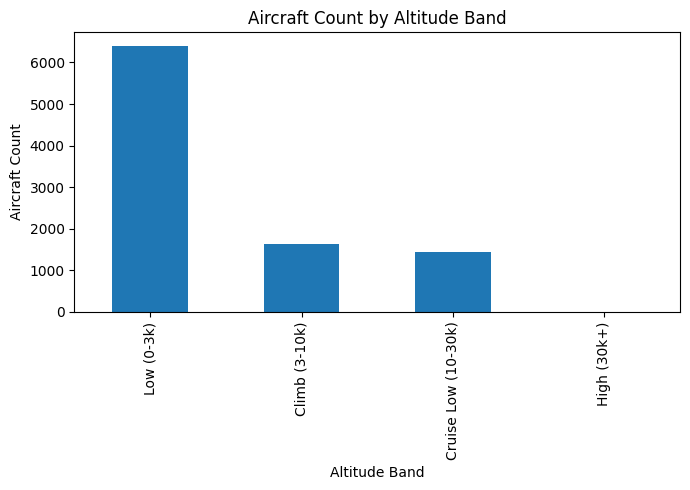

In [12]:
plt.figure(figsize=(7,5))
df['alt_band'].value_counts().plot(kind='bar')
plt.xlabel("Altitude Band")
plt.ylabel("Aircraft Count")
plt.title("Aircraft Count by Altitude Band")
plt.tight_layout()
plt.show()


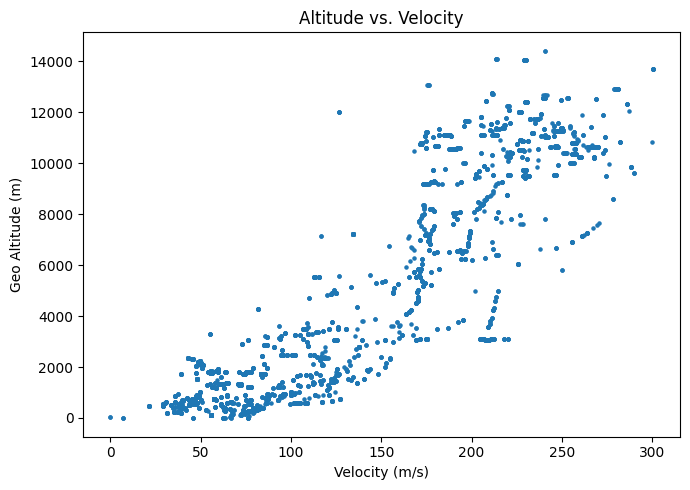

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df['velocity'], df['geo_altitude'], s=5)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Geo Altitude (m)")
plt.title("Altitude vs. Velocity")
plt.tight_layout()
plt.show()


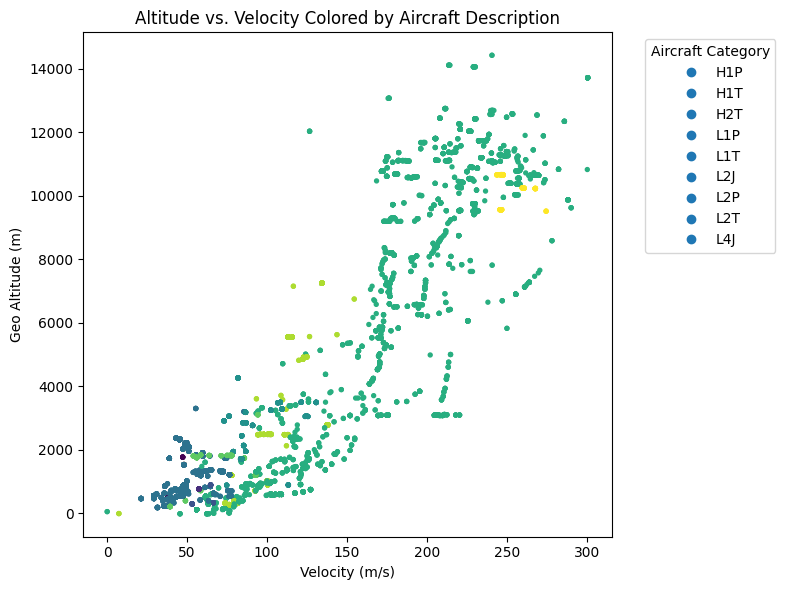

In [14]:
import matplotlib.pyplot as plt
import pandas as pd


# Drop rows missing required values
plot_df = df[['velocity','geo_altitude','Description']].dropna()

# Map categories → integers
plot_df['desc_code'] = plot_df['Description'].astype('category').cat.codes

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    plot_df['velocity'],
    plot_df['geo_altitude'],
    c=plot_df['desc_code'],   # color by category code
    s=8
)

# Build legend manually
categories = plot_df['Description'].astype('category').cat.categories
handles = []
for i, cat in enumerate(categories):
    handles.append(
        plt.Line2D(
            [], [], 
            marker='o', linestyle='', 
            label=cat
        )
    )

plt.legend(handles=handles, title="Aircraft Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Velocity (m/s)")
plt.ylabel("Geo Altitude (m)")
plt.title("Altitude vs. Velocity Colored by Aircraft Description")
plt.tight_layout()
plt.show()


Using categories:
 ['L2J', 'L1P', 'L2T', 'L1T']


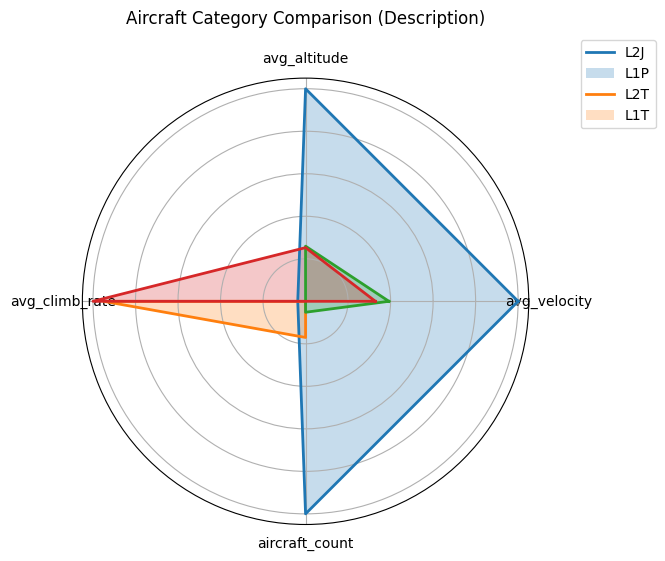

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Keep only rows with needed columns
metrics_df = df[['Description', 'velocity', 'geo_altitude', 'climb_rate_ratio', 'icao24']].dropna()

# Aggregate by Description
agg = (
    metrics_df
    .groupby('Description')
    .agg(
        avg_velocity=('velocity', 'mean'),
        avg_altitude=('geo_altitude', 'mean'),
        avg_climb_rate=('climb_rate_ratio', 'mean'),
        aircraft_count=('icao24', 'nunique')
    )
)

# Pick top N categories to keep the chart readable
top_n = 4
top_desc = agg.sort_values('aircraft_count', ascending=False).head(top_n)
print("Using categories:\n", top_desc.index.tolist())

# Normalize each metric to 0–1 for fair comparison
norm = top_desc.copy()
for col in ['avg_velocity', 'avg_altitude', 'avg_climb_rate', 'aircraft_count']:
    col_min = norm[col].min()
    col_max = norm[col].max()
    if col_max == col_min:
        norm[col] = 0.5  # if all same, just put them in middle
    else:
        norm[col] = (norm[col] - col_min) / (col_max - col_min)

# Radar chart setup
labels = ['avg_velocity', 'avg_altitude', 'avg_climb_rate', 'aircraft_count']
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for idx, (desc, row) in enumerate(norm.iterrows()):
    values = row[labels].tolist()
    values += values[:1]  # close the loop

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Set axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_yticklabels([])  # hide radial labels; it's relative 0–1 anyway
ax.set_title("Aircraft Category Comparison (Description)", pad=20)

# Legend with category names
ax.legend(norm.index.tolist(), loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


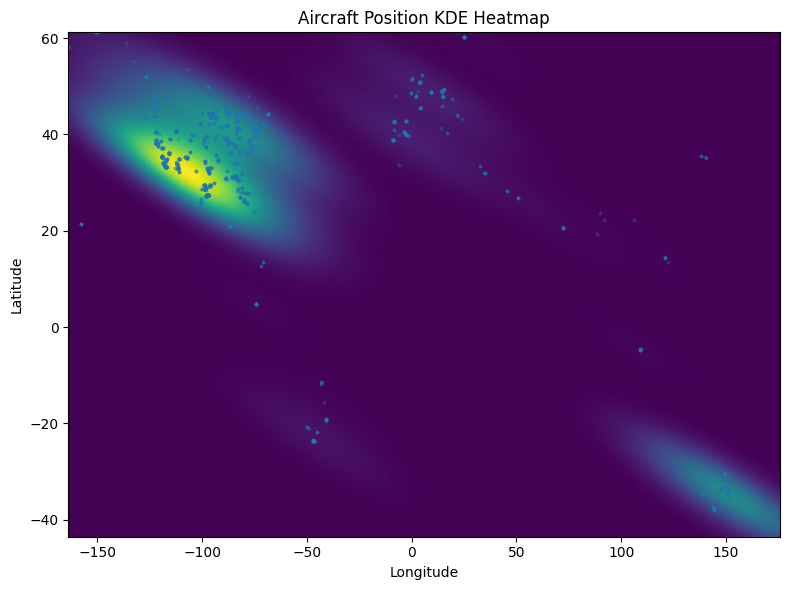

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------
# Option A: load from CSV (comment this out if you already have df)
# -------------------------------------------------------------------
# df = pd.read_csv("df_aircraft.csv")  # <-- adjust path as needed

# -------------------------------------------------------------------
# KDE heatmap of aircraft positions
# -------------------------------------------------------------------
def plot_aircraft_kde(df, sample_frac=1.0):
    """
    Plots a KDE heatmap of aircraft positions (lat/lon) using gaussian_kde.
    df must have 'latitude' and 'longitude' columns.
    sample_frac can be <1.0 to speed up on huge datasets.
    """
    # Keep only rows with valid coordinates
    coords = df[['latitude', 'longitude']].dropna()

    if sample_frac < 1.0 and len(coords) > 0:
        coords = coords.sample(frac=sample_frac, random_state=42)

    if coords.empty:
        print("No valid latitude/longitude data to plot.")
        return

    # Prepare data for KDE: x = longitude, y = latitude
    x = coords['longitude'].values
    y = coords['latitude'].values
    xy = np.vstack([x, y])

    # Fit KDE
    kde = gaussian_kde(xy)

    # Create grid over the data range
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Resolution of the grid (200x200 is usually fine)
    xx, yy = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    grid_positions = np.vstack([xx.ravel(), yy.ravel()])

    # Evaluate KDE on the grid
    zz = np.reshape(kde(grid_positions).T, xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))

    # Show KDE heatmap
    plt.imshow(
        np.rot90(zz),
        extent=[x_min, x_max, y_min, y_max],
        aspect='auto'
    )

    # Overlay raw points (light scatter)
    plt.scatter(x, y, s=3, alpha=0.3)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Aircraft Position KDE Heatmap")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------
# Usage
# -------------------------------------------------------------------

# If df is already defined in your script:
# plot_aircraft_kde(df)

# If you want to read from CSV here:
# df_csv = pd.read_csv("df_aircraft.csv")
# plot_aircraft_kde(df_csv)
plot_aircraft_kde(df, sample_frac=0.3)

Using existing DataFrame 'df' with 10000 rows.
------------------------------

Generating Velocity Distribution (Violin Plot) by WTC...


/var/folders/r3/w_7frpzn2m9_yscy82mn8cl40000gn/T/ipykernel_25913/576522988.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_use['snapshot_ts'] = pd.to_datetime(df_to_use['snapshot_ts'], unit='s', errors='coerce')
/var/folders/r3/w_7frpzn2m9_yscy82mn8cl40000gn/T/ipykernel_25913/576522988.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_use['alt_band'] = pd.cut(df_to_use['geo_altitude'], bins=[0, 10000, 25000, 45000], labels=['Low', 'Mid', 'High'], include_lowest=True)
/var/folders/r3/w_

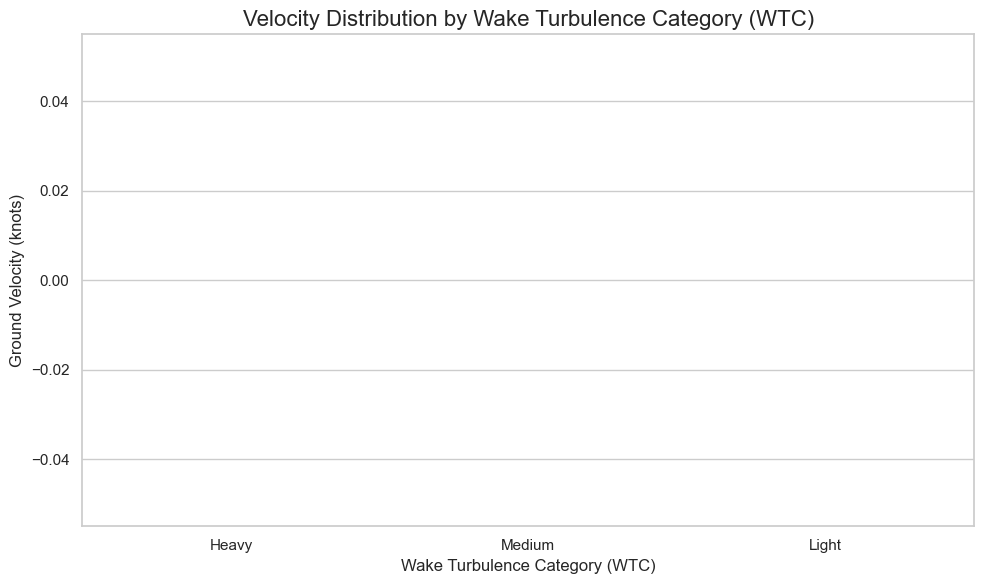


Generating Altitude vs. Velocity Scatter Plot...


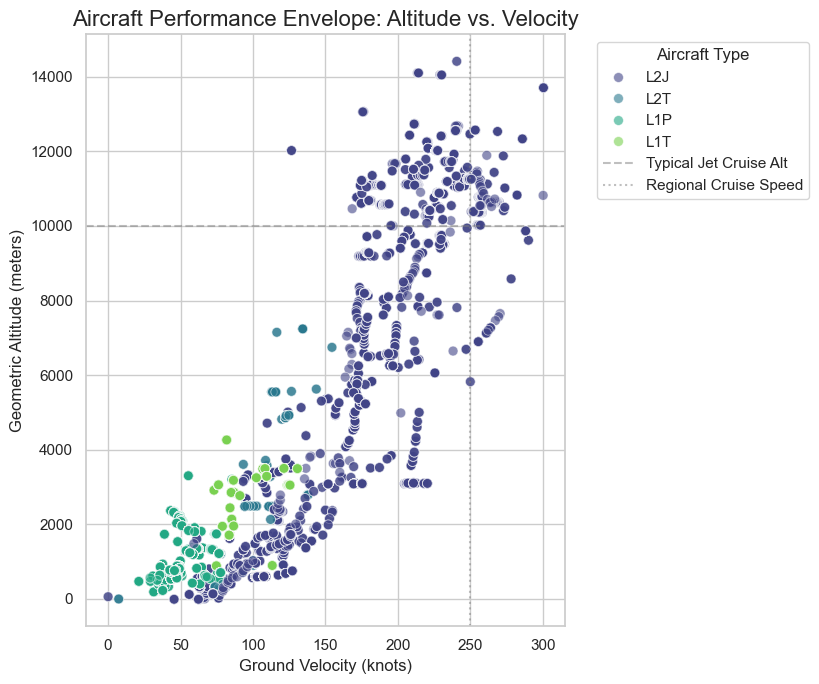


Generating Vertical Rate Distribution Bar Chart...


/var/folders/r3/w_7frpzn2m9_yscy82mn8cl40000gn/T/ipykernel_25913/576522988.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


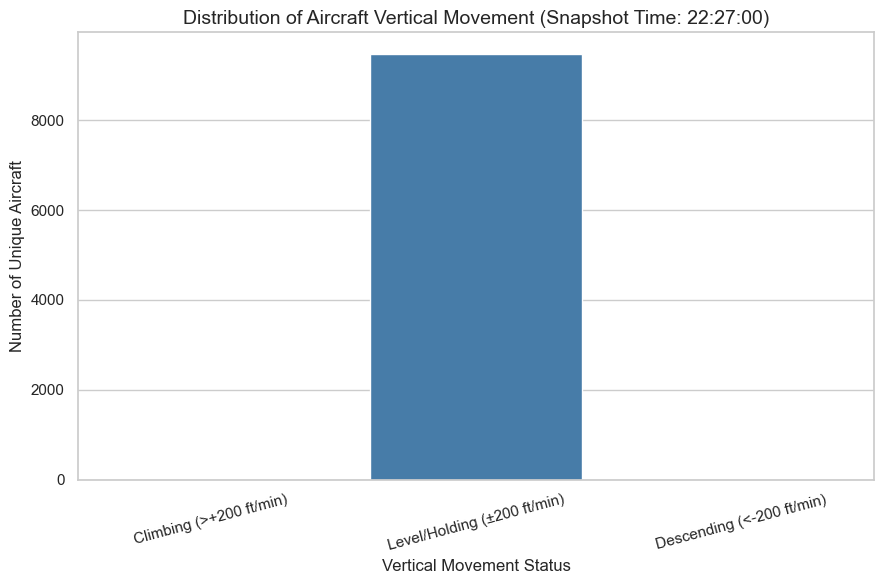

------------------------------
Visualization generation complete. Three static charts should be displayed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a standard style for aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Removed create_mock_df function as the user confirmed they have 'df' set.

def generate_violin_plot(df):
    """
    Visualization 1: Velocity Distribution (Violin Plot) by Wake Turbulence Category (WTC).
    Shows the statistical distribution of speed for different aircraft size classes.
    """
    print("\nGenerating Velocity Distribution (Violin Plot) by WTC...")
    
    if 'WTC' not in df.columns:
        print("[Skipping] 'WTC' column not found for violin plot grouping. Ensure column names are correct.")
        return

    # Filter out any WTC categories with too few observations (e.g., less than 5)
    valid_wtc = df['WTC'].value_counts()
    valid_wtc = valid_wtc[valid_wtc >= 5].index.tolist()
    plot_df = df[df['WTC'].isin(valid_wtc)].copy()
    
    if plot_df.empty:
        print("Not enough data with valid WTC categories to create the violin plot.")
        return

    plt.figure(figsize=(10, 6))
    
    # Create the violin plot [Image of a violin plot comparing data distributions]
    sns.violinplot(
        data=plot_df, 
        x='WTC', 
        y='velocity', 
        palette='Set2', 
        inner='quartile', # Show mean/quartiles inside the violin
        order=['Heavy', 'Medium', 'Light'] # Explicit order for WTC
    )

    plt.title('Velocity Distribution by Wake Turbulence Category (WTC)', fontsize=16)
    plt.xlabel('Wake Turbulence Category (WTC)', fontsize=12)
    plt.ylabel('Ground Velocity (knots)', fontsize=12)
    plt.tight_layout()
    plt.show()


def generate_scatter_plot(df):
    """
    Altitude vs. Velocity Scatter Plot     
    Shows the performance profile of different aircraft categories.
    """
    print("\nGenerating Altitude vs. Velocity Scatter Plot...")
    
    # Filter for the top 4 most common descriptions to keep the plot clean
    if 'Description' not in df.columns:
        print("[Skipping] 'Description' column not found for scatter plot grouping. Ensure column names are correct.")
        return

    top_n_desc = df['Description'].value_counts().nlargest(4).index.tolist()
    plot_df = df[df['Description'].isin(top_n_desc)].copy() # Use a copy for plotting
    
    if plot_df.empty:
        print("Not enough data with filtered descriptions to create the scatter plot.")
        return

    plt.figure(figsize=(10, 7))
    
    # Use seaborn scatterplot for better aesthetics and automatic legend
    sns.scatterplot(
        data=plot_df, 
        x='velocity', 
        y='geo_altitude', 
        hue='Description', 
        palette='viridis', 
        s=50, # size of points
        alpha=0.6 # transparency
    )

    plt.title('Aircraft Performance Envelope: Altitude vs. Velocity', fontsize=16)
    plt.xlabel('Ground Velocity (knots)', fontsize=12)
    plt.ylabel('Geometric Altitude (meters)', fontsize=12)
    
    # Add context lines
    plt.axhline(10000, color='gray', linestyle='--', alpha=0.5, label='Typical Jet Cruise Alt')
    plt.axvline(250, color='gray', linestyle=':', alpha=0.5, label='Regional Cruise Speed')

    # Improve legend placement
    plt.legend(title='Aircraft Type', bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def generate_vertical_rate_distribution(df):
    """
    Visualization 3: Vertical Rate Distribution (Current Snapshot)
    Shows the proportion of climbing, descending, and level traffic.
    """
    print("\nGenerating Vertical Rate Distribution Bar Chart...")
    
    # Define vertical movement status
    # Assuming tolerance for level flight is +/- 200 ft/min
    LEVEL_TOLERANCE = 200
    
    df_copy = df.copy() # Work on a copy to prevent SettingWithCopyWarning
    
    df_copy['Vertical_Status'] = np.select(
        [df_copy['vertical_rate'] > LEVEL_TOLERANCE, 
         df_copy['vertical_rate'] < -LEVEL_TOLERANCE],
        ['Climbing (>+200 ft/min)', 'Descending (<-200 ft/min)'],
        default='Level/Holding (±200 ft/min)'
    )
    
    status_counts = df_copy['Vertical_Status'].value_counts().reset_index()
    status_counts.columns = ['Status', 'Count']
    
    # Sort for logical flow
    order = ['Climbing (>+200 ft/min)', 'Level/Holding (±200 ft/min)', 'Descending (<-200 ft/min)']
    status_counts['Status'] = pd.Categorical(status_counts['Status'], categories=order, ordered=True)
    status_counts = status_counts.sort_values('Status')

    plt.figure(figsize=(9, 6))
    
    # Create the bar chart 
    sns.barplot(
        x='Status', 
        y='Count', 
        data=status_counts, 
        palette=['#4daf4a', '#377eb8', '#e41a1c'] # Green, Blue, Red
    )

    # Use the snapshot timestamp if available, otherwise use a placeholder
    snapshot_time = 'N/A'
    if 'snapshot_ts' in df.columns and not df['snapshot_ts'].empty:
        # Check if the column is already datetime before calling dt.strftime
        if pd.api.types.is_datetime64_any_dtype(df['snapshot_ts']):
            snapshot_time = df['snapshot_ts'].iloc[0].strftime('%H:%M:%S')
        else:
             # This fallback handles cases where the conversion failed earlier
             try:
                 snapshot_time = pd.to_datetime(df['snapshot_ts'].iloc[0], errors='coerce').strftime('%H:%M:%S')
             except:
                 pass
        
    plt.title(f"Distribution of Aircraft Vertical Movement (Snapshot Time: {snapshot_time})", fontsize=14)
    plt.xlabel('Vertical Movement Status', fontsize=12)
    plt.ylabel('Number of Unique Aircraft', fontsize=12)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


# --- Main Execution Block ---

if __name__ == '__main__':
    
    df_to_use = df 
    print(f"Using existing DataFrame 'df' with {len(df_to_use)} rows.")

    try:
        # 1. Data Type Conversion and Preparation (Ensure stability)
        # Attempt to convert critical columns to numeric, coercing errors to NaN
        for col in ['latitude', 'longitude', 'geo_altitude', 'velocity', 'vertical_rate']:
             df_to_use[col] = pd.to_numeric(df_to_use[col], errors='coerce')
        
        # Drop rows where critical plotting data is missing
        df_to_use = df_to_use.dropna(subset=['geo_altitude', 'velocity', 'vertical_rate'])

        # Ensure timestamp is datetime type for display
        if 'snapshot_ts' in df_to_use.columns:
            # Handle both epoch and existing datetime format
            if pd.api.types.is_numeric_dtype(df_to_use['snapshot_ts']):
                 df_to_use['snapshot_ts'] = pd.to_datetime(df_to_use['snapshot_ts'], unit='s', errors='coerce')
            elif not pd.api.types.is_datetime64_any_dtype(df_to_use['snapshot_ts']):
                 df_to_use['snapshot_ts'] = pd.to_datetime(df_to_use['snapshot_ts'], errors='coerce')

        # Add derived columns needed for analysis (check if they exist first)
        if 'altitude_km' not in df_to_use.columns:
             df_to_use['altitude_km'] = df_to_use['geo_altitude'] * 0.0003048
        if 'alt_band' not in df_to_use.columns:
             df_to_use['alt_band'] = pd.cut(df_to_use['geo_altitude'], bins=[0, 10000, 25000, 45000], labels=['Low', 'Mid', 'High'], include_lowest=True)

        # 2. Aggressive Sampling for Stability
        if len(df_to_use) > MAX_ROWS_FOR_STABILITY:
            print(f"[WARNING] DataFrame size ({len(df_to_use)}) exceeds stability limit. Sampling to {MAX_ROWS_FOR_STABILITY} rows.")
            # Use random_state=42 for reproducibility during debugging
            df_to_use = df_to_use.sample(MAX_ROWS_FOR_STABILITY, random_state=42).copy()
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Failed during DataFrame preparation (Type conversion/Cleanup): {e}")
        # If preparation fails, stop to prevent further errors
        df_to_use = pd.DataFrame() 
        
    # Check if we have any data left after cleaning
    if df_to_use.empty:
         print("\n[ERROR] No valid data available to generate visualizations after cleanup.")
    else:
        # 3. Generate Visualizations (All non-interactive)
        print("-" * 30)
        generate_violin_plot(df_to_use)
        generate_scatter_plot(df_to_use)
        generate_vertical_rate_distribution(df_to_use)
        print("-" * 30)
        print("Visualization generation complete. Three static charts should be displayed.")